In [61]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np


In [62]:
#global variables
epsilon = 0.9  # initial greedy police
alpha = 0.1  # initial learning rate
gamma = 0.999  # discount factor
niter = int(1e3)
NT = int(10)  # 10 periods
dt = 1  # send child order each dt
dT = 60  # decisions are made at each dT

kappa = 1/60  # second time scale
theta = 1
sigma = 0.02/np.sqrt(60)
phi = 0.000001
c = 1000

Qmax = 10  # max inventory
Qmin = -10  # min inventory
q_grid = np.array(range(Qmin, Qmax + 1))

a_grid = list(range(-5, 6))  # actions
# a_grid.reverse

T_grid = np.array(range(NT+1))

s_min = theta - 5 * sigma / np.sqrt(2 * kappa)  # min price
s_max = theta + 5 * sigma / np.sqrt(2 * kappa)  # max price
Ns = 51
ds = (s_max - s_min) / (Ns - 1)
s_grid = np.arange(s_min, s_max + ds / 2, ds)

In [63]:
def SimMRStep(S0, q0, x, kappa, theta, sigma, dt, phi):
    S1 = theta + (S0 - theta) * np.exp(-kappa * dt) + sigma * np.sqrt(dt) * np.random.randn()
    # S1 = S0 + kappa*(theta-S0)* dt + sigma * np.sqrt(dt) * np.random.randn()
    # x(i+1) = x(i)+th*(mu-x(i))*dt+sig*sqrt(dt)*randn
    q1 = q0 + x
    # phi = 0
    # reward = q0 * (S1 - S0) - phi * np.square(x)
    reward = q0 * (S1 - S0) - phi * np.square(x)
    return reward, q1, S1

In [64]:
class env():
    def __init__(self,state_space,action_space):
        env.state_space = state_space
        env.action_space = action_space
    def reset(self):
        return np.array([np.random.choice(state_space.s), 0, 0])
    def step(self, state, action):
        period_reward = 0
        s = state[0]
        T = state[1]
        q = state[2]
        q0 = q
        x = action / dT  # average order size per dt
        t = 1
        while t < dT + 1:
            reward_, q, s = SimMRStep(s, q, x, kappa, theta, sigma, dt, phi)
            period_reward += reward_
            t += 1
        if T < NT-1:
            done = False
            return np.array([s_grid[abs(s - np.array(s_grid)).argmin()], T+1, q0 + action]), period_reward, done
        else:
            done = True
            reward_, q_, s_ = SimMRStep(s, q, x, kappa, theta, sigma, dt, phi)
            terminal_reward = q * (s_ - s) - c * phi * np.square(q)
            period_reward += terminal_reward
            return np.array([s_grid[abs(s - np.array(s_grid)).argmin()], T+1, q0 + action]), period_reward, done
    def adms_actions(self,q = None):
        if q == None:
            return self.action_space.a
        else:
            lowerbound = max(-5, -10 - q)
            upperbound = min(5, 10 - q)
            return np.array([item for item in self.action_space.a if (lowerbound <= item <= upperbound)])
    def adms_actions_indeces(self,q):
        return np.where(np.isin(self.action_space.a, self.adms_actions(q)))[0]
    def sample_action(self, q=None):
        return np.random.choice(self.adms_actions(q))

In [65]:
class state_space():
    def __init__(self, s_grid, T_grid, q_grid):
        self.s = s_grid
        self.T = T_grid
        self.q = q_grid
        self.dim = 3

In [66]:
class action_space():
    def __init__(self, a_grid):
        self.a = a_grid
        #self.idx = [i for i in range(len(self.a))]
        self.dim = len(self.a)

In [67]:
#Initialize env

state_space = state_space(s_grid, T_grid, q_grid)
action_space = action_space(a_grid)
env = env(state_space, action_space)


In [68]:
# Create Deep Q Network Class (In this case 2 fully connected layers with intermediate ReLu activation)
# MSE loss function
# Will use GPU if available otherwise CPU
# Adam Optimizer
class DeepQNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims,
                 n_actions):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        actions = self.fc3(x)

        return actions


# Creates Replay Buffer Class
# General version of Replay Buffer that stores transitions up to a maximum memory size
# If memory is full it cycles through and replaces old data
# Can sample a given batch size from memory
class ReplayBuffer:
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape),
                                     dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_shape),
                                         dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int64)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.new_state_memory[index] = state_
        self.terminal_memory[index] = done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size, replace=False)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        dones = self.terminal_memory[batch]

        return states, actions, rewards, states_, dones


# Creates Agent class
# Implements DDQ Learning
# Takes input parameters, currently decays epsilon linearly up to a fixed minimum
# Agent class manages action selection, epsilon update, transition storage, memory sampling, and learning updates
# replace gives the number of learning steps before replacing target network
class Agent:
    def __init__(self, env, gamma, epsilon, lr, n_actions, input_dims,
                 mem_size, batch_size, eps_min=0.01, eps_dec=5e-7,
                 replace=1000, fc1_dims=64, fc2_dims=64):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.lr = lr
        self.n_actions = n_actions
        self.input_dims = input_dims
        self.batch_size = batch_size
        self.eps_min = eps_min
        self.eps_dec = eps_dec
        self.replace_target_cnt = replace
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.learn_step_counter = 0

        self.memory = ReplayBuffer(mem_size, input_dims, n_actions)

        self.q_eval = DeepQNetwork(self.lr, self.input_dims, self.fc1_dims, self.fc2_dims,
                                   self.n_actions)

        self.q_next = DeepQNetwork(self.lr, self.input_dims, self.fc1_dims, self.fc2_dims,
                                   self.n_actions)

    def choose_action(self, observation):
        state = T.tensor([observation], dtype=T.float).to(self.q_eval.device)
        if np.random.random() > self.epsilon:
            actions_values = self.q_eval.forward(state)
            adms_actions_values = actions_values[:,self.env.adms_actions_indeces(state[0,2])]
            action_index = T.argmax(adms_actions_values).item()
            action = self.env.adms_actions(state[0,2])[action_index]
        else:
            action = np.random.choice(self.env.adms_actions(state[0,2]))
        return action

    def store_transition(self, state, action, reward, state_, done):
        self.memory.store_transition(state, action, reward, state_, done)

    def sample_memory(self):
        state, action, reward, new_state, done = \
            self.memory.sample_buffer(self.batch_size)

        states = T.tensor(state).to(self.q_eval.device)
        rewards = T.tensor(reward).to(self.q_eval.device)
        dones = T.tensor(done).to(self.q_eval.device)
        actions = T.tensor(action).to(self.q_eval.device)
        states_ = T.tensor(new_state).to(self.q_eval.device)

        return states, actions, rewards, states_, dones

    def replace_target_network(self):
        if self.learn_step_counter % self.replace_target_cnt == 0:
            self.q_next.load_state_dict(self.q_eval.state_dict())

    def decrement_epsilon(self):
        self.epsilon = self.epsilon - self.eps_dec \
            if self.epsilon > self.eps_min else self.eps_min

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return None

        self.q_eval.optimizer.zero_grad()

        self.replace_target_network()

        states, actions, rewards, states_, dones = self.sample_memory()


        indices = np.arange(self.batch_size)

        q_pred = self.q_eval.forward(states)[indices, actions]
        q_next = self.q_next.forward(states_)
        q_eval = self.q_eval.forward(states_)
        
        max_actions_indeces = np.zeros(self.batch_size)
        ##Need to vectorize this part
        
        for i in range(self.batch_size):
            adms_actions_values = q_eval[i,self.env.adms_actions_indeces(states_[i,2])]
            action_index = T.argmax(adms_actions_values).item()
            action = self.env.adms_actions(states_[i,2])[action_index]
            max_actions_indeces[i] = int(self.env.action_space.a.index(action))      

        q_next[dones] = 0.0
        q_target = rewards + self.gamma * q_next[indices, max_actions_indeces]

        loss = self.q_eval.loss(q_target, q_pred).to(self.q_eval.device)
        loss.backward()

        self.q_eval.optimizer.step()
        self.learn_step_counter += 1

        self.decrement_epsilon()

In [69]:
import matplotlib.pyplot as plt
#import numpy as np
#import gym


def plot_learning_curve(x, scores, epsilons, filename, lines=None):
    fig = plt.figure()
    ax = fig.add_subplot(111, label="1")
    ax2 = fig.add_subplot(111, label="2", frame_on=False)

    ax.plot(x, epsilons, color="C0")
    ax.set_xlabel("Game", color="C0")
    ax.set_ylabel("Epsilon", color="C0")
    ax.tick_params(axis='x', colors="C0")
    ax.tick_params(axis='y', colors="C0")

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = np.mean(scores[max(0, t-20):(t+1)])

    ax2.scatter(x, running_avg, color="C1")
    # ax2.xaxis.tick_top()
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    # ax2.set_xlabel('x label 2', color="C1")
    ax2.set_ylabel('Score', color="C1")
    # ax2.xaxis.set_label_position('top')
    ax2.yaxis.set_label_position('right')
    # ax2.tick_params(axis='x', colors="C1")
    ax2.tick_params(axis='y', colors="C1")

    if lines is not None:
        for line in lines:
            plt.axvline(x=line)

    plt.savefig(filename)

episode  1 score 0.13 average score 0.13 epsilon 1.00
episode  2 score 0.17 average score 0.15 epsilon 1.00
episode  3 score -0.04 average score 0.09 epsilon 1.00
episode  4 score 0.16 average score 0.10 epsilon 1.00
episode  5 score 0.02 average score 0.09 epsilon 1.00
episode  6 score -0.16 average score 0.05 epsilon 1.00
episode  7 score 0.07 average score 0.05 epsilon 1.00
episode  8 score -0.06 average score 0.04 epsilon 1.00
episode  9 score -0.18 average score 0.01 epsilon 1.00
episode  10 score 0.13 average score 0.02 epsilon 1.00
episode  11 score 0.04 average score 0.03 epsilon 1.00
episode  12 score 0.02 average score 0.03 epsilon 1.00
episode  13 score -0.11 average score 0.01 epsilon 1.00
episode  14 score -0.05 average score 0.01 epsilon 1.00
episode  15 score -0.11 average score 0.00 epsilon 1.00
episode  16 score 0.20 average score 0.02 epsilon 1.00
episode  17 score 0.01 average score 0.02 epsilon 1.00
episode  18 score 0.05 average score 0.02 epsilon 1.00
episode  19 

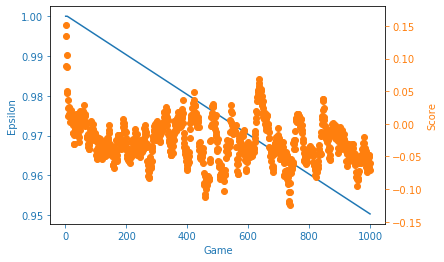

In [70]:
#import gym
# from DDQNetwork_OptimalExecution import Agent
#from DDQNetworkFile import Agent
#from utils import plot_learning_curve
import numpy as np

if __name__ == '__main__':
    env = env
    agent = Agent(env, gamma=0.99, epsilon=1.0, lr=0.001, n_actions=11, input_dims=[3], mem_size=10000,
                  batch_size=64, eps_min=0.01, eps_dec=5e-6, replace=1000, fc1_dims=64,
                  fc2_dims=64)
    scores, eps_history = [], []
    n_games = 1000

    for i in range(n_games):
        score = 0
        done = False
        observation = env.reset()
        while not done:
            action = agent.choose_action(observation)
            observation_, reward, done = agent.env.step(observation, action)
            score += reward
            agent.store_transition(observation, action, reward,
                                   observation_, done)
            agent.learn()
            observation = observation_
        scores.append(score)
        eps_history.append(agent.epsilon)

        avg_score = np.mean(scores[-100:])

        print('episode ', i+1, 'score %.2f' % score,
              'average score %.2f' % avg_score,
              'epsilon %.2f' % agent.epsilon)
    x = [i + 1 for i in range(n_games)]
    filename = 'lunar_lander_ddqn.png'
    plot_learning_curve(x, scores, eps_history, filename)